# Solving Benzene with RHF

In this notebook we will calculate the eigenvalues and eigenvectors of the fock matrix for the benzene molecule. We want to obtain the same molecular orbitals for the $\pi$-system of benzene like we got from solving the Hückel-matrix. 

Here we are going to use the program we wrote in our bootcamp for restricted hartree fock. Note that in this folder there is a notebook that does the same thing but uses only pyscf for solving RHF for this system.  [The other notebook](./rhf_pyscf.ipynb)

We now that this code works for a watermolecule.

In [33]:
from pyscf import gto, scf
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [34]:
benzene_geometry_with_H ='''
   C        0.00000        1.40272        0.00000
   C        1.21479        0.70136        0.00000
   C        1.21479       -0.70136        0.00000
   C        0.00000       -1.40272        0.00000
   C       -1.21479       -0.70136        0.00000
   C       -1.21479        0.70136        0.00000
   H        0.00000        2.49164        0.00000
   H        2.15741        1.24582        0.00000
   H        2.15741       -1.24582        0.00000
   H        0.00000       -2.49164        0.00000
   H       -2.15741       -1.24582        0.00000
   H       -2.15741        1.24582        0.00000
'''

mol = gto.M(atom=benzene_geometry_with_H, basis='sto-3g')#'ccpvdz'

pz_indices = [i for i, label in enumerate(mol.ao_labels()) if 'C 2pz' in label]
print(mol.ao_labels())
print(pz_indices)


['0 C 1s    ', '0 C 2s    ', '0 C 2px   ', '0 C 2py   ', '0 C 2pz   ', '1 C 1s    ', '1 C 2s    ', '1 C 2px   ', '1 C 2py   ', '1 C 2pz   ', '2 C 1s    ', '2 C 2s    ', '2 C 2px   ', '2 C 2py   ', '2 C 2pz   ', '3 C 1s    ', '3 C 2s    ', '3 C 2px   ', '3 C 2py   ', '3 C 2pz   ', '4 C 1s    ', '4 C 2s    ', '4 C 2px   ', '4 C 2py   ', '4 C 2pz   ', '5 C 1s    ', '5 C 2s    ', '5 C 2px   ', '5 C 2py   ', '5 C 2pz   ', '6 H 1s    ', '7 H 1s    ', '8 H 1s    ', '9 H 1s    ', '10 H 1s    ', '11 H 1s    ']
[4, 9, 14, 19, 24, 29]


In [35]:
MAXITER = 40
E_conv = 1.0e-9

In [36]:
S = mol.intor('int1e_ovlp')
T = mol.intor('int1e_kin')
V = mol.intor('int1e_nuc')
H_core = T + V
eri = mol.intor('int2e')


In [37]:
enuc = mol.get_enuc()
ndocc = mol.nelec[0]
print(ndocc)
print(enuc)

21
202.3888768104643


In [38]:
# ==> Inspecting S for AO orthonormality <==
def controleer_orthonormaliteit(matrix):
    is_ortho = np.allclose(np.eye(len(matrix[0])), matrix)
    if is_ortho:
        print("De matrix is orthonormaal.")
    else:
        print("De matrix is niet orthonormaal.")
controleer_orthonormaliteit(S)

De matrix is niet orthonormaal.


In [39]:
# ==> Construct AO orthogonalization matrix A <==
from scipy.linalg import fractional_matrix_power
A = fractional_matrix_power(S, -0.5)
A = np.asarray(A)
ASA = A@S@A

# Check orthonormality
controleer_orthonormaliteit(ASA)


De matrix is orthonormaal.


In [40]:
# ==> Compute C & D matrices with CORE guess <==
# Transformed Fock matrix
F_p = A @ H_core @ A

# Diagonalize F_p for eigenvalues & eigenvectors with NumPy
epsilon, C_p = np.linalg.eigh(F_p) 
epsilon_1, C_p_1 = sp.linalg.eigh(F_p) 
print(epsilon[ndocc])
print(epsilon)
print(epsilon_1)
print(C_p.round(4))
print(C_p_1.round(4))
# Transform C_p back into AO basis
C = A @ C_p
# Grab occupied orbitals
C_occ = C[:, :ndocc]

# Build density matrix from occupied orbitals
D = np.einsum('ik, kj -> ij',C_occ, C_occ.T, optimize=True)


-12.845424677982642
[-27.45855102 -27.45837901 -27.45831825 -27.45786702 -27.45780136
 -27.45745774 -14.82381414 -14.69605128 -14.69601728 -14.36300885
 -14.36297843 -14.02669918 -13.54143699 -13.3192221  -13.31921718
 -13.16013863 -13.16007164 -13.09218684 -12.92531624 -12.88372095
 -12.88369467 -12.84542468 -12.84538113 -12.83557833 -12.68493179
 -12.6274638  -12.62726032 -12.59593282 -12.5956971  -12.58853214
  -8.89216182  -8.87091156  -8.87041684  -8.84945257  -8.84894651
  -8.83960639]
[-27.45855102 -27.45837901 -27.45831825 -27.45786702 -27.45780136
 -27.45745774 -14.82381414 -14.69605128 -14.69601728 -14.36300885
 -14.36297843 -14.02669918 -13.54143699 -13.3192221  -13.31921718
 -13.16013863 -13.16007164 -13.09218684 -12.92531624 -12.88372095
 -12.88369467 -12.84542468 -12.84538113 -12.83557833 -12.68493179
 -12.6274638  -12.62726032 -12.59593282 -12.5956971  -12.58853214
  -8.89216182  -8.87091156  -8.87041684  -8.84945257  -8.84894651
  -8.83960639]
[[-0.3713 -0.      0.552  

In [41]:
def sorted_matrix_on_first_row(array):
    sorted_indices = np.argsort(array[0, :])
    sorted_array = array[:, sorted_indices]
    return sorted_array
# Voorbeeld array
print(sorted_matrix_on_first_row(np.array([[3, 1, 4],
                  [2, 5, 0], [0,9,7]])))



[[1 3 4]
 [5 2 0]
 [9 0 7]]


In [42]:
def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)
print(check_symmetric(F_p))

print(np.sort(epsilon).round(6) == np.sort(epsilon_1).round(6))
print(sorted_matrix_on_first_row(C_p))
print(sorted_matrix_on_first_row(C_p_1))

True
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
[[-5.95801208e-01 -4.33874719e-01 -3.71340320e-01 ...  4.57278587e-02
   5.65607014e-02  5.52016611e-01]
 [-7.28125266e-02 -5.56732850e-02 -3.59936885e-02 ... -3.68594174e-01
  -3.57765747e-01  5.87154459e-02]
 [-7.79779637e-13  1.10673382e-12  3.97143092e-13 ...  1.81180175e-10
   2.48927168e-14  2.95596970e-13]
 ...
 [ 1.03294387e-02 -7.62295744e-03  5.87459605e-03 ... -3.41987419e-02
   4.22842720e-02  8.98334525e-03]
 [ 4.59111004e-03 -6.90278578e-03 -6.77276836e-03 ...  1.71103513e-02
   2.11571400e-02 -5.05342101e-03]
 [-4.59111004e-03 -6.90278578e-03  6.77276836e-03 ...  1.71103512e-02
  -2.11571400e-02 -5.05342101e-03]]
[[-4.33874719e-01 -3.71340320e-01 -3.05046720e-02 ...  5.65607014e-02
   5.52016611e-01  5.95801208e-01]
 [-5.56732850e-02 -3.59936885e-02 

In [43]:
# ==> SCF Iterations <==
# Pre-iteration energy declarations
SCF_E = 0.0
E_old = 0.0

print('==> Starting SCF Iterations <==\n')

# Begin Iterations
for scf_iter in range(1, MAXITER + 1):
    print(f'Iteratie {scf_iter}')
    # Build Fock matrix
    J = np.einsum('pqrs,rs->pq', eri, D, optimize=True)
    K = np.einsum('prqs,rs->pq', eri, D, optimize=True)
    
    F = H_core + 2 * J - K
    if scf_iter == 3:
        Fo = F.round(6)
    print(F)
    # Compute RHF energy
    
    SCF_E = enuc + np.einsum('pq,pq->', (H_core + F), D, optimize=True)
    SCF_E = enuc + np.sum( D * (H_core + F))
    
    
    
    # SCF Converged?
    if (abs(SCF_E - E_old) < E_conv):
        break
    E_old = SCF_E
    
    print(check_symmetric(A @ F @ A))
    # Compute new orbital guess
    epsilon, C_p = np.linalg.eigh(A @ F @ A)
    print(epsilon[ndocc-1], epsilon[ndocc])
    C = A @ C_p
    C_occ = C[:, :ndocc]  
    D = np.einsum('pi,iq->pq', C_occ, C_occ.T, optimize=True)
    print(SCF_E)
    # MAXITER exceeded?
    if (scf_iter == MAXITER):
        raise Exception("Maximum number of SCF iterations exceeded.")
# Post iterations
print('\nSCF converged.')
print('Final RHF Energy: %.8f [Eh]' % (SCF_E))

==> Starting SCF Iterations <==

Iteratie 1
[[-9.35960016e+00 -2.59427558e+00 -1.14896292e-15 ... -1.21786910e-04
  -1.04330503e-03 -5.74683678e-02]
 [-2.59427558e+00 -3.62002140e-01 -2.22463107e-14 ... -1.15967340e-03
  -6.58375014e-03 -7.65805721e-02]
 [-1.14483618e-15 -2.22389381e-14  4.93429835e-01 ...  7.10549258e-16
   8.04540689e-03  8.50759703e-02]
 ...
 [-1.21786910e-04 -1.15967340e-03  7.09604393e-16 ... -1.74154982e-01
  -3.40811184e-02 -9.37779091e-04]
 [-1.04330503e-03 -6.58375014e-03  8.04540689e-03 ... -3.40811184e-02
  -1.74057037e-01 -3.40583424e-02]
 [-5.74683678e-02 -7.65805721e-02  8.50759703e-02 ... -9.37779091e-04
  -3.40583424e-02 -1.74057037e-01]]
True
0.7459364602527211 1.1666290023005177
-207.8713977813108
Iteratie 2
[[-1.17604489e+01 -3.14439191e+00 -8.73162220e-16 ... -1.45907185e-04
  -1.22593588e-03 -6.93136628e-02]
 [-3.14439191e+00 -2.06117978e+00  2.07325476e-14 ... -5.82832255e-03
  -2.11462555e-02 -2.14016569e-01]
 [-8.57868193e-16  2.06841922e-14 -1.

In [44]:
mf = scf.RHF(mol)
SCF_E_pyscf = mf.kernel()
print(SCF_E)
np.isclose(SCF_E_pyscf, SCF_E, rtol=0., atol=1e-06)

converged SCF energy = -227.889369554885
-227.88936955487566


True

Now we have done the rhf on benzene, we can try to make the same molecular orbitals as we made with pyscf. 

First we normalize the molecular orbitals expressed in ao basis with the next function.

In [45]:
def normaliseer(eigenvectors):
    eigenvectors = eigenvectors.T
    for index, eigenvector in enumerate(eigenvectors):
        eigenvectors[index] = eigenvector * (np.dot(eigenvector, eigenvector))**(-1/2)
    return eigenvectors.T

C = normaliseer(C)
print(np.dot(C[:, 17], C[:, 17]))

1.0


In [46]:
C = C.round(6)
mo_eigenvalues = epsilon
print(mo_eigenvalues)
pz_orbitals = C[pz_indices]

print(pz_orbitals)

[-11.02901115 -11.02900927 -11.02897137 -11.02869457 -11.02869276
 -11.02856753  -1.08425361  -0.95102852  -0.95100882  -0.76430904
  -0.764227    -0.65787951  -0.59418817  -0.54919426  -0.53160963
  -0.53155165  -0.4514624   -0.43156466  -0.43156238  -0.27707825
  -0.27706644   0.26679964   0.26681593   0.49844229   0.57703496
   0.64591524   0.64605348   0.71068306   0.72454292   0.72459186
   0.8775814    0.87780258   0.88722561   0.88736395   1.07467081
   1.13676451]
[[-0.        0.       -0.        0.       -0.        0.       -0.
  -0.       -0.       -0.        0.       -0.       -0.        0.
  -0.       -0.       -0.408234 -0.       -0.       -0.       -0.57734
  -0.        0.577355 -0.408256  0.        0.       -0.        0.
   0.        0.       -0.       -0.       -0.       -0.        0.
   0.      ]
 [-0.       -0.        0.       -0.       -0.       -0.       -0.
   0.       -0.       -0.        0.       -0.       -0.       -0.
  -0.       -0.       -0.408255 -0.       -

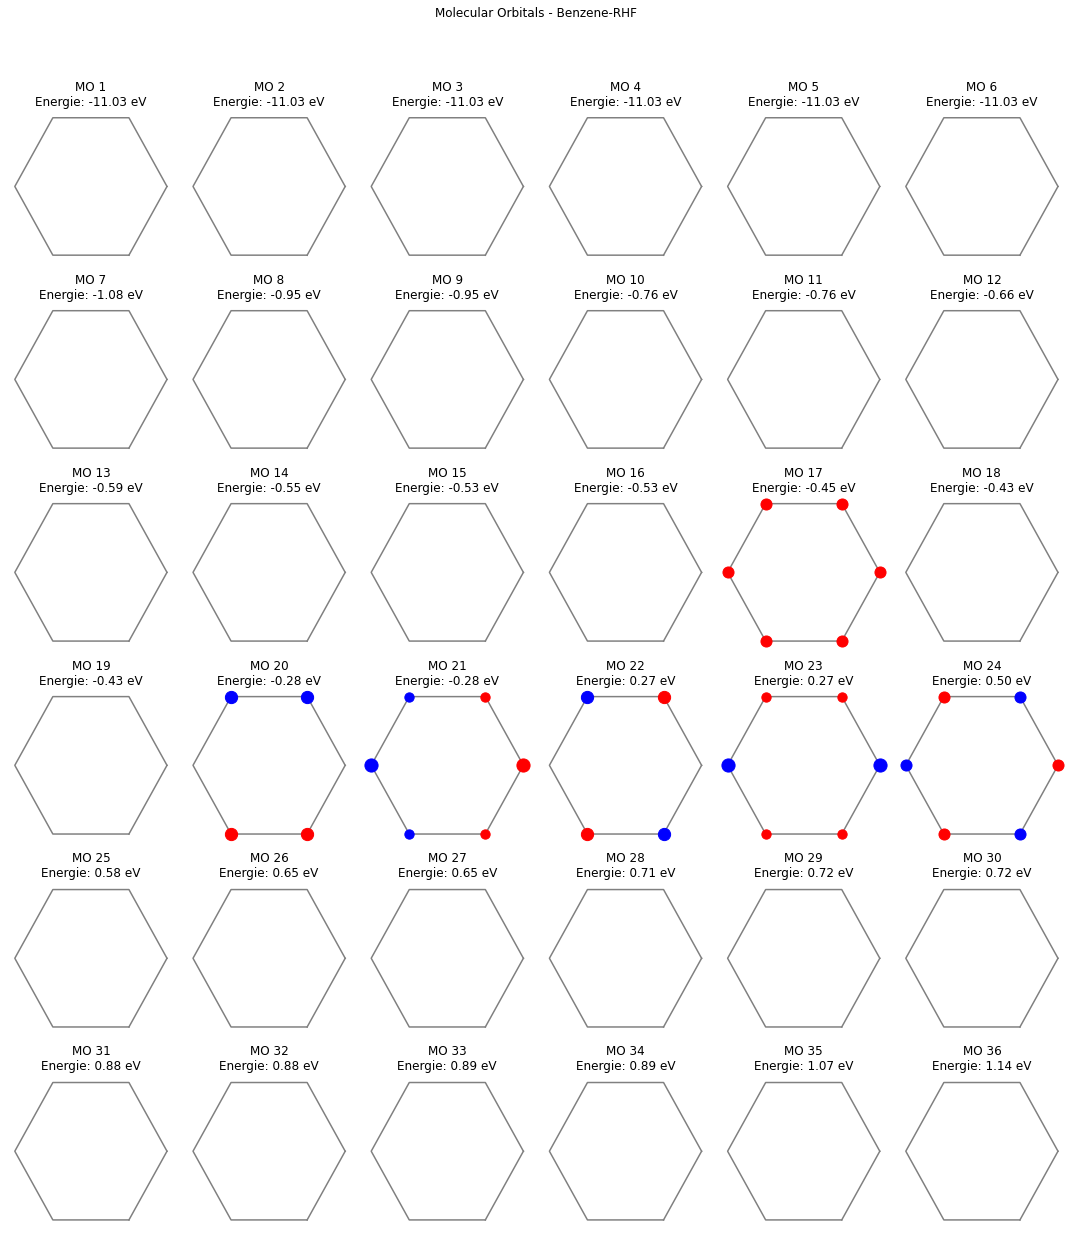

In [47]:
def plotting_of_the_system(eigenvalues, eigenvectors, num_atoms, num_rows):
    eigenvectors = eigenvectors.T

    # Bepaal het aantal rijen en kolommen voor de subplots
    num_mos = len(eigenvalues)
    # num_rows Bijvoorbeeld 2 rijen, zodat de plots onder elkaar worden geplaatst
    num_cols = (num_mos + num_rows - 1) // num_rows

    # Plot de moleculaire orbitalen
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))
    
    for i in range(num_mos):
        ax = axs[i // num_cols, i % num_cols]  # Bepaal de juiste subplot

        # Plot de benzeenring
        benzene_x = np.cos(2 * np.pi / num_atoms * np.arange(num_atoms))
        benzene_y = np.sin(2 * np.pi / num_atoms * np.arange(num_atoms))
        ax.plot(benzene_x, benzene_y, linestyle='-', color='grey')
        ax.plot([benzene_x[-1], benzene_x[0]], [benzene_y[-1], benzene_y[0]], linestyle='-', color='grey')
        
        # Plot de atoomcoëfficiënten als gekleurde bollen
        for j in range(num_atoms):
            c = eigenvectors[i, j]

            if c > 0:
                color = 'blue'
            else:
                color = 'red'

            size = abs(c) * 300  # Schaal de grootte van de bol op basis van de coëfficiënt
            ax.scatter(benzene_x[j], benzene_y[j], s=size, marker='o', color=color, zorder=2)

        ax.set_title(f'MO {i + 1}\nEnergie: {eigenvalues[i]:.2f} eV')

        ax.axis('off')
    
    # Stel het algehele plot-titel in
    plt.suptitle('Molecular Orbitals - Benzene-RHF')

    # Zorg ervoor dat de subplots niet overlappen
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Toon de plot
    plt.show()


# Hieronder wordt de functie aangeroepen met de gegeven eigenschappen
plotting_of_the_system(mo_eigenvalues, pz_orbitals, 6, 6)
#plotting_of_the_system(mo_eigenvalues_exp, pz_orbitals_exp, 6, 19)


Checking which other atomic orbitals play an important rule in the MO's of the delocalisation of the $\pi$-system. MO 17, 20-23, 30 (if start counting from 1).

In [48]:
def seeking_for_all_contributions_in_MO(coefficienten_matrix, mol, number_of_mo):
    coe_mo_in_ato = coefficienten_matrix[:, number_of_mo]
    list_indices_with_val = []
    for index, waarde in enumerate(coe_mo_in_ato):
        if waarde != 0:
            list_indices_with_val.append(index)
    mol_ato_orb = mol.ao_labels()
    list_ato_orb_with_val = []
    list_val = []
    for index in list_indices_with_val:
        list_ato_orb_with_val.append(mol_ato_orb[index])
        list_val.append(coe_mo_in_ato[index])
    return (list_ato_orb_with_val, list_val)

ato, val = seeking_for_all_contributions_in_MO(C, mol, 16)
print(ato)
print(val)


['0 C 2pz   ', '1 C 2pz   ', '2 C 2pz   ', '3 C 2pz   ', '4 C 2pz   ', '5 C 2pz   ']
[-0.408234, -0.408255, -0.408255, -0.408234, -0.408255, -0.408255]


[[-0.408234 -0.       -0.57734  -0.        0.577355 -0.408256]
 [-0.408255  0.5      -0.288686 -0.5      -0.28867   0.408244]
 [-0.408255  0.5       0.288686  0.5      -0.28867  -0.408244]
 [-0.408234  0.        0.57734  -0.        0.577355  0.408256]
 [-0.408255 -0.5       0.288686 -0.5      -0.28867  -0.408244]
 [-0.408255 -0.5      -0.288686  0.5      -0.28867   0.408244]]


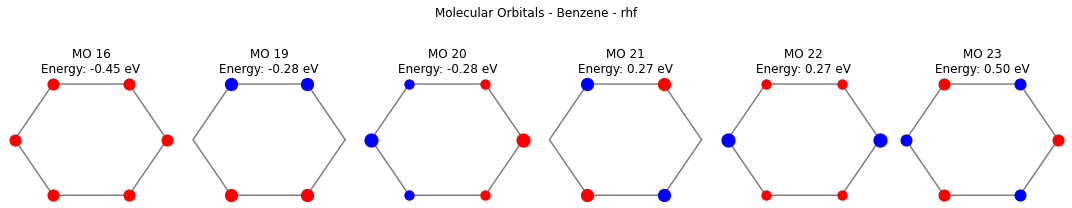

In [49]:
pi_orbitals = pz_orbitals[:, [16, 19, 20, 21, 22, 23]]
print(pi_orbitals)
pi_eigenvalues = np.array([])
for i in [16, 19, 20, 21, 22, 23]:
    pi_eigenvalues = np.append(pi_eigenvalues, mo_eigenvalues[i])



def plotting_of_the_system2(eigenvalues, eigenvectors, num_atoms, mo_numbers ):
    eigenvectors = eigenvectors.T

    # Plot de moleculaire orbitalen
    fig, axs = plt.subplots(1, len(eigenvalues), figsize=(15, 3))
    
    for i in range(len(eigenvalues)):
        ax = axs[i]
        
        # Plot de benzeenring
        benzene_x = np.cos(2 * np.pi / num_atoms * np.arange(num_atoms))
        benzene_y = np.sin(2 * np.pi / num_atoms * np.arange(num_atoms))
        ax.plot(benzene_x, benzene_y, linestyle='-', color='grey')
        ax.plot([benzene_x[-1], benzene_x[0]], [benzene_y[-1], benzene_y[0]], linestyle='-', color='grey')
        # Plot de atoomcoëfficiënten als gekleurde bollen
        for j in range(num_atoms):
            c = eigenvectors[i, j]

            if c > 0:
                color = 'blue'
            else:
                color = 'red'

            size = abs(c) * 300  # Schaal de grootte van de bol op basis van de coëfficiënt
            ax.scatter(benzene_x[j], benzene_y[j], s=size, marker='o', color=color, zorder=2)

        ax.set_title(f'MO {mo_numbers[i]}\nEnergy: {eigenvalues[i]:.2f} eV')

        ax.axis('off')
    # Stel het algehele plot-titel in
    plt.suptitle('Molecular Orbitals - Benzene - rhf')

    # Zorg ervoor dat de subplots niet overlappen
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Toon de plot
    plt.show()

plotting_of_the_system2(pi_eigenvalues, pi_orbitals, 6, [16, 19, 20, 21, 22, 23])

4 orbitals have not the same structure of the orbitals in huckel. So we want to make some symmetrie operations.